## Object Detection on Pascal VOC dataset

### Single Object Detection

#### Libraries

In [10]:
#! ln -s ../fastai/fastai/ .

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [15]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [13]:
# check to make sure you set the device
#torch.cuda.set_device(0)

#### Pascal VOC data

First we will try to visualize the training data, which contains data about **class** in an image and **bounding box** related data in each image. Bounding box data contains **height, width, top left coordinate, top right coordinate** around each object in image

In [28]:
! ls pascal_data/PASCAL_VOC/

pascal_test2007.json  pascal_train2012.json pascal_val2012.json
pascal_train2007.json pascal_val2007.json


In [31]:
! ls pascal_data/VOCdevkit/VOC2007/

Annotations        JPEGImages         SegmentationObject
ImageSets          SegmentationClass


In [32]:
PATH = Path('pascal_data/PASCAL_VOC/')

In [33]:
list(PATH.iterdir())

[PosixPath('pascal_data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_val2012.json')]

Our training data is in `pascal_train2007.json`. Let's see how it looks like

In [108]:
train_json = json.load((PATH/'pascal_train2007.json').open()) #  PATH.open() creates a io.text wrapper that is like file path

In [41]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

What's there in each of those keys. Let's see one by one

In [43]:
train_json['images'][:2]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480}]

`images` has data about `image ids` and `image files`. Let's see where are these images. e.g. `000012.jpg`. 
(They are present in `VOCdevkit/VOC2007/` as can be seen in above ls statement)

Let's just move `VOC2007` into `PASCAL_VOC` to make it accessible via PATH iterator

In [45]:
# ! mv pascal_data/VOCdevkit/VOC2007 pascal_data/PASCAL_VOC/

In [68]:
list(PATH.iterdir()) # how PATH looks like now

[PosixPath('pascal_data/PASCAL_VOC/pascal_test2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_train2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_train2012.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_val2007.json'),
 PosixPath('pascal_data/PASCAL_VOC/pascal_val2012.json'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017')]

In [70]:
JPEGS = 'VOC2017/JPEGImages'

In [71]:
IMAGE_PATH = PATH/JPEGS

In [74]:
list(IMAGE_PATH.iterdir())[:4]  

[PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000005.jpg'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000007.jpg'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000009.jpg'),
 PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000012.jpg')]

So, here are our jpg images. 

Let's now look at other 3 keys of `train_json`

In [78]:
train_json['type'] # doesn't interest me

'instances'

In [80]:
train_json['annotations'][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

Ok. So, it has `bbox` data, `id` of image to map with `jpg` using `images` key. `category_id` as final label. Categori ID has name in `categories` key. Let's take a look

In [82]:
train_json['categories']

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

It has only **20 unique** categories in data

How much is total training data?

In [83]:
len(list(IMAGE_PATH.iterdir()))

5011

#### Visualizing images with bounding boxes

 The bbox field specifies the bounding box of the object in the image, as [left,top,right,bottom]

In [120]:
def show_img(im, figsize=None, ax=None):
    """
    use of subplots to show images. no need x axis, y axis
    """
    
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [189]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [207]:
def bb_hw(b):
    """
    x,y, width, height format
    """
    return (b[1], b[0], b[3] - b[1], b[2] - b[0])

In [208]:
def draw_rect(ax, b):
    """
    b: output of bb_hw
    
    4 args of Rectance = (x,y) , width, height
    """
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:],  fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [209]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

Let's get some image. To make our life easier, let's give strings a name. So that we can use `tab` to complete the sentences. Also let's make dictionary of 

In [210]:
image_sample = train_json['images'][0]['file_name']

In [211]:
image_sample_id = train_json['images'][0]['id']

In [212]:
# get bbox and object name for this image id
train_annotation = collections.defaultdict(lambda : []) # 

for i in train_json['annotations']:
    if not i['ignore']:
        bb = i['bbox']
        bb = bb_hw(bb)
        train_annotation[i['image_id']].append((bb, i['category_id']))

In [213]:
train_annotation[image_sample_id] # here 12 is image id, 7 is category id

[((96, 155, 78, 41), 7)]

In [214]:
image_sample

'000012.jpg'

In [215]:
IMAGE_PATH/'000012.jpg'

PosixPath('pascal_data/PASCAL_VOC/VOC2017/JPEGImages/000012.jpg')

In [216]:
im = open_image(IMAGE_PATH/image_sample)

In [217]:
cat_id = train_annotation[image_sample_id][0][1] - 1

In [218]:
train_annotation[image_sample_id][0]

((96, 155, 78, 41), 7)

In [219]:
train_annotation[image_sample_id][0][0]

(96, 155, 78, 41)

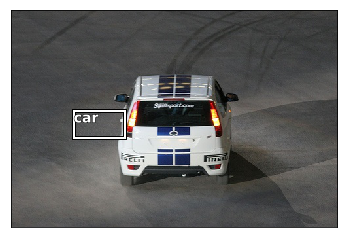

In [221]:
ax = show_img(im)
b = train_annotation[image_sample_id][0][0]
draw_rect(ax, b)
draw_text(ax, b[:2], train_json['categories'][cat_id]['name'])